In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
import math
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import numpy as np
import math

In [24]:
print("Loading the data...", end='')
# Load data
raw_data_x = pd.read_csv("data/Data_X.csv", index_col='ID')
raw_dataNew_x = pd.read_csv("data/DataNew_X.csv", index_col='ID')
raw_data_y = pd.read_csv("data/Data_Y.csv", index_col='ID')
print(" OK")

print("Merging and filtering the data...", end='')
# Merge data and filter by country
data_xy = pd.merge(raw_data_x, raw_data_y, on='ID')
data_fr = data_xy[data_xy['COUNTRY'] == 'FR'].drop(['COUNTRY', 'DAY_ID'], axis=1)
print(" OK")

print("Starting KNN imputation...", end='')
# Impute missing values using KNN imputation
imputer = KNNImputer(n_neighbors=5)
data_fr_imputed = pd.DataFrame(imputer.fit_transform(data_fr), columns=data_fr.columns)
print(" OK")

print("Starting feature selection...", end='')
# Feature selection using SelectKBest
X_fr_imputed = data_fr_imputed.drop('TARGET', axis=1)
y_fr_imputed = data_fr_imputed['TARGET']
selector = SelectKBest(score_func=f_regression, k=10)
selector.fit(X_fr_imputed, y_fr_imputed)
selected_features = X_fr_imputed.columns[selector.get_support()]
print(" OK")
print(list(selected_features))

print("Preparing data for modeling...", end='')
# Prepare data for modeling
X = X_fr_imputed[selected_features]
y = y_fr_imputed
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
print(" OK")

Loading the data... OK
Merging and filtering the data... OK
Starting KNN imputation... OK
Starting feature selection... OK
['DE_CONSUMPTION', 'DE_NET_EXPORT', 'DE_NET_IMPORT', 'DE_HYDRO', 'FR_HYDRO', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_RAIN', 'GAS_RET', 'CARBON_RET']
Preparing data for modeling... OK


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import numpy as np
import math

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

params = {
    'linear': {
        'm__fit_intercept': [True, False],
    },
    'ridge': {
        'm__alpha': np.logspace(start=-3, stop=3).tolist()
    },
    'lasso': {
        'm__alpha': np.logspace(start=-3, stop=3).tolist()
    },
    'knn': {
        's__k': [10],
        'm__n_neighbors': range(1, 50),
        'm__weights': ['uniform', 'distance'],
        'm__metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'decision_tree': {
        'm__max_depth': [None] + list(range(1, 50)),
        'm__min_samples_split': range(2, 20),
        'm__min_samples_leaf': range(1, 20),
    },
    'random_forest': {
        's__k': [10],
        'm__n_estimators': [10, 20],  
        'm__max_depth': [None, 3],  
        'm__min_samples_split': range(2, 10), 
        'm__min_samples_leaf': range(1, 10),
    }
}

distributions = {
    'decision_tree': {
        'm__max_depth': [None] + list(range(1, 50)),
        'm__min_samples_split': range(2, 20),
        'm__min_samples_leaf': range(1, 20),
    },
    'random_forest': {
        's__k': [10],
        'm__n_estimators': [10, 20],  
        'm__max_depth': [None, 3],  
        'm__min_samples_split': range(2, 10), 
        'm__min_samples_leaf': range(1, 10),
    }
}

pipelines = {
    'linear': Pipeline([('imputer', SimpleImputer()), ('s', StandardScaler()), ('m', LinearRegression())]),
    'ridge': Pipeline([('imputer', SimpleImputer()), ('s', StandardScaler()), ('m', Ridge())]),
    'lasso': Pipeline([('imputer', SimpleImputer()), ('s', StandardScaler()), ('m', Lasso())]),
    'knn': Pipeline([('imputer', SimpleImputer()), ('s', SelectKBest(f_regression)), ('m', KNeighborsRegressor())]),  
    'decision_tree': Pipeline([('imputer', SimpleImputer()), ('s', StandardScaler()), ('m', DecisionTreeRegressor())]),
    'random_forest': Pipeline([('imputer', SimpleImputer()), ('s', SelectKBest(f_regression)), ('m', RandomForestRegressor(n_jobs=-1))])
}


# pipelines = {
#     'linear': Pipeline([('s', StandardScaler()), ('m', LinearRegression())]),
#     'ridge': Pipeline([('s', StandardScaler()), ('m', Ridge())]),
#     'lasso': Pipeline([('s', StandardScaler()), ('m', Lasso())]),
#     'knn': Pipeline([('s', SelectKBest(f_regression)), ('m', KNeighborsRegressor())]),  
#     'decision_tree': Pipeline([('s', StandardScaler()), ('m', DecisionTreeRegressor())]),
#     'random_forest': Pipeline([('s', SelectKBest(f_regression)), ('m', RandomForestRegressor(n_jobs=-1))])
# }


print("Starting nested cross-validation for model selection and evaluation...")

def spearmanr_scorer(y, y_pred):
    try:
        correlation, _ = spearmanr(y, y_pred)
        if np.isfinite(correlation):
            return correlation
        else:
            print("NOT FINITE")
            return 0.0 
    except Exception as e:
        print(f"Error calculating Spearman correlation: {e}")
        return 0.0 

spearman_scoring = make_scorer(spearmanr_scorer)

scoring_metrics = {
    'spearmanr': spearman_scoring
}

cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}
feature_importances = {}

for model_name, pipeline in pipelines.items():
    print(f"\tCross-validation for {model_name.capitalize()} model...", end='')
    if model_name in ['decision_tree', 'random_forest']:
        rs_inner = RandomizedSearchCV(pipeline, distributions[model_name], 
                                      cv=cv_outer, n_jobs=-1, scoring=spearman_scoring, 
                                      refit='spearmanr', n_iter=50)
    else:
        rs_inner = GridSearchCV(pipeline, params[model_name], 
                          cv=cv_outer, n_jobs=-1, scoring=spearman_scoring, refit='spearmanr')

    rs_inner.fit(X_train, y_train)

    y_pred = rs_inner.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    spearman_corr, _ = spearmanr(y_test, y_pred)

    results[model_name] = {
        'best_params': rs_inner.best_params_,
        'best_score': rs_inner.best_score_,
        'R2': r2,
        'RMSE': rmse,
        'spearman_corr': spearman_corr,
        'y_pred': y_pred,
    }

    if hasattr(rs_inner.best_estimator_.named_steps['m'], 'feature_importances_'):
        feature_importances[model_name] = dict(zip(selected_features, rs_inner.best_estimator_.named_steps['m'].feature_importances_))
    elif hasattr(rs_inner.best_estimator_.named_steps['m'], 'coef_'):
        feature_importances[model_name] = dict(zip(selected_features, rs_inner.best_estimator_.named_steps['m'].coef_))
    else:
        print(f' No feature importance or coef found for {model_name.capitalize()}', end='')

    print(" OK")
print("Nested cross-validation completed successfully.")

Starting nested cross-validation for model selection and evaluation...
	Cross-validation for Linear model... OK
	Cross-validation for Ridge model... OK
	Cross-validation for Lasso model... OK
	Cross-validation for Knn model... No feature importance or coef found for Knn OK
	Cross-validation for Decision_tree model... OK
	Cross-validation for Random_forest model... OK
Nested cross-validation completed successfully.


In [26]:
print("Results:")
for model_name in results:
    print(f"Results for {model_name}:")
    print(f"\tBest parameters             : {results[model_name]['best_params']}")
    print(f"\tBest cross-validation score : {results[model_name]['best_score']:.5f}")
    print(f"\tSpearman correlation        : {results[model_name]['spearman_corr']:.5f}")
    print(f"\tR2 score                    : {results[model_name]['R2']:.8f}")
    print(f"\tRMSE                        : {results[model_name]['RMSE']:.4f}")
    
best_spearman_model = None
best_spearman_score = -np.inf

best_r2_model = None
best_r2_score = -np.inf

best_rmse_model = None
best_rmse_score = np.inf

for model_name, result in results.items():
    if result['spearman_corr'] > best_spearman_score:
        best_spearman_model = model_name
        best_spearman_score = result['spearman_corr']

    if result['R2'] > best_r2_score:
        best_r2_model = model_name
        best_r2_score = result['R2']

    if result['RMSE'] < best_rmse_score:
        best_rmse_model = model_name
        best_rmse_score = result['RMSE']

print(f"Best model for Spearman correlation: {best_spearman_model} with score {best_spearman_score:.5f}")
print(f"Best model for R2 score: {best_r2_model} with score {best_r2_score:.8f}")
print(f"Best model for RMSE: {best_rmse_model} with score {best_rmse_score:.4f}")

Results:
Results for linear:
	Best parameters             : {'m__fit_intercept': True}
	Best cross-validation score : 0.15904
	Spearman correlation        : 0.13138
	R2 score                    : 0.01127854
	RMSE                        : 1.1807
Results for ridge:
	Best parameters             : {'m__alpha': 429.1934260128778}
	Best cross-validation score : 0.17134
	Spearman correlation        : 0.09571
	R2 score                    : 0.01156561
	RMSE                        : 1.1805
Results for lasso:
	Best parameters             : {'m__alpha': 0.0013257113655901094}
	Best cross-validation score : 0.15812
	Spearman correlation        : 0.12846
	R2 score                    : 0.01144816
	RMSE                        : 1.1806
Results for knn:
	Best parameters             : {'m__metric': 'euclidean', 'm__n_neighbors': 22, 'm__weights': 'uniform', 's__k': 10}
	Best cross-validation score : 0.16063
	Spearman correlation        : 0.02242
	R2 score                    : -0.01139233
	RMSE           

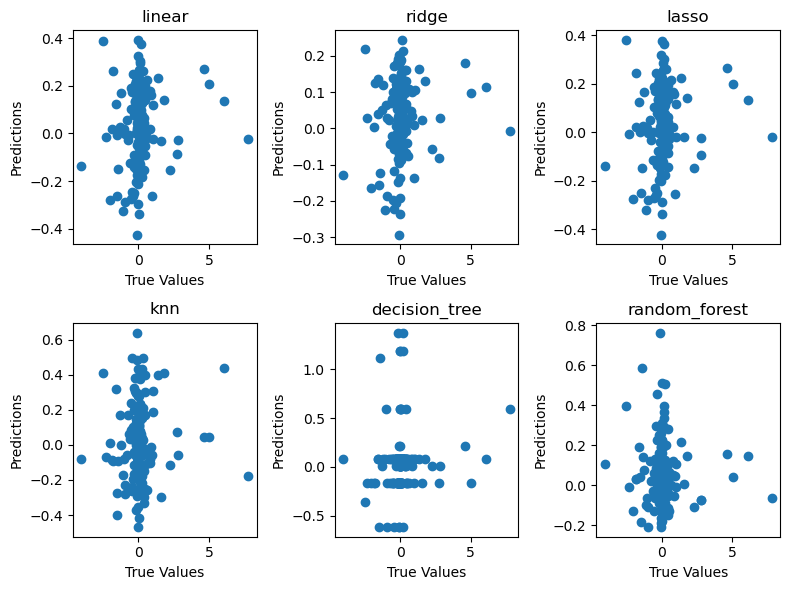

In [27]:
import matplotlib.pyplot as plt



fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))

for i, (model_name, result) in enumerate(results.items()):
    y_pred = result['y_pred']

    row, col = i // 3, i % 3
    axs[row, col].scatter(y_test, y_pred)
    axs[row, col].set_xlabel('True Values')
    axs[row, col].set_ylabel('Predictions')
    axs[row, col].set_title(model_name)

plt.tight_layout()

plt.show()


Creating plot for linear model...


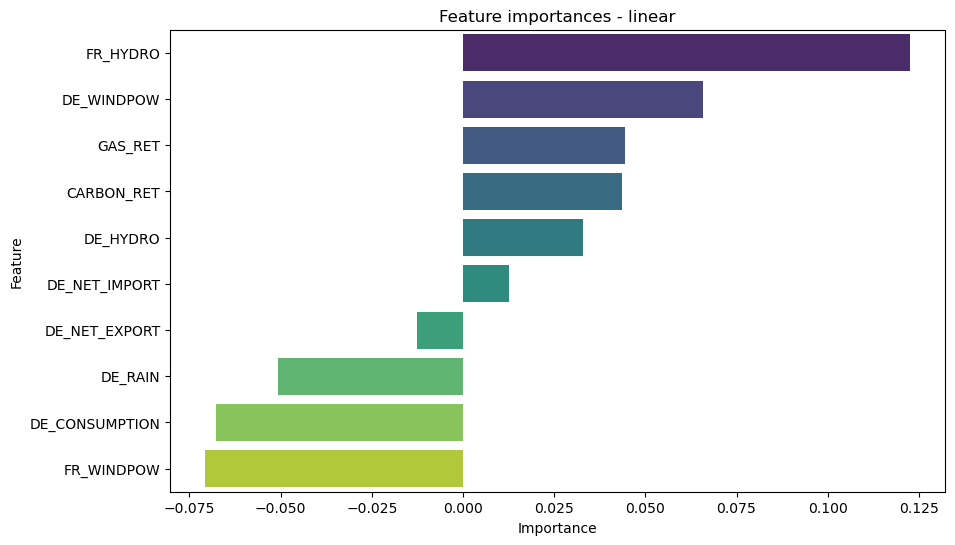

Plot for linear model created.
Creating plot for ridge model...


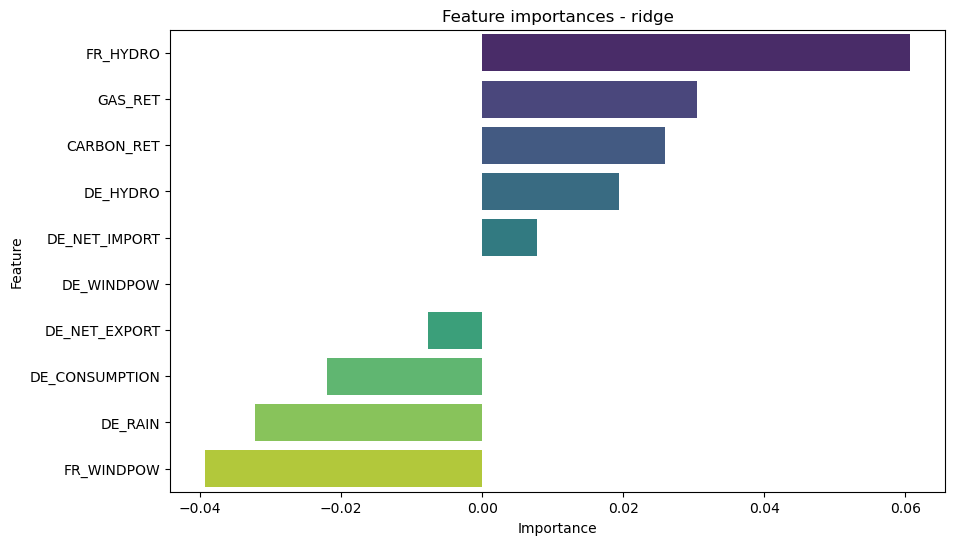

Plot for ridge model created.
Creating plot for lasso model...


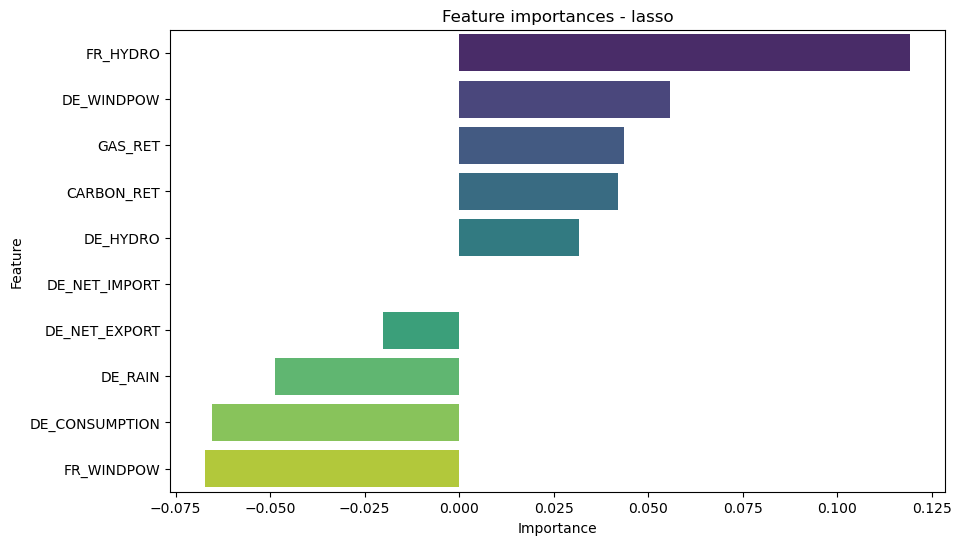

Plot for lasso model created.
Creating plot for decision_tree model...


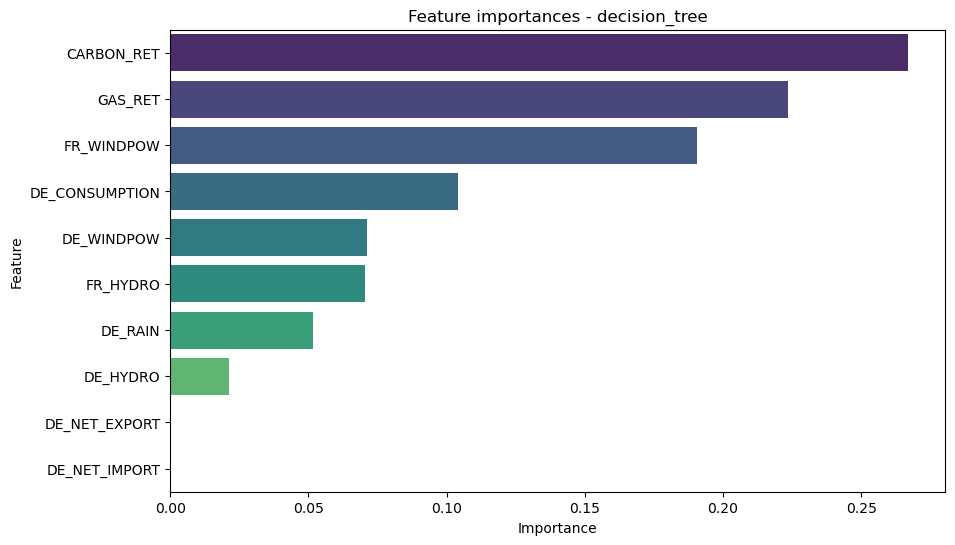

Plot for decision_tree model created.
Creating plot for random_forest model...


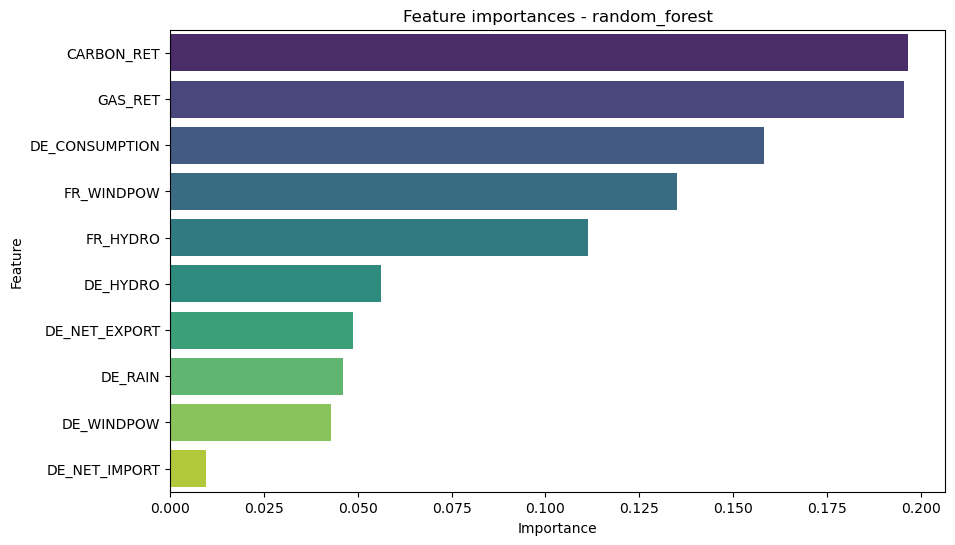

Plot for random_forest model created.


In [28]:
for model_name in feature_importances:
    print(f"Creating plot for {model_name} model...")
    importances = feature_importances[model_name]
    importances_df = pd.DataFrame.from_dict(importances, orient='index', columns=['importance'])
    importances_df.sort_values('importance', ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances_df, y=importances_df.index, x='importance', palette='viridis')
    plt.title(f'Feature importances - {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
    print(f"Plot for {model_name} model created.")

Creating plot for linear model...
Plot for linear model created.
Creating plot for ridge model...
Plot for ridge model created.
Creating plot for lasso model...
Plot for lasso model created.
Creating plot for decision_tree model...
Plot for decision_tree model created.
Creating plot for random_forest model...
Plot for random_forest model created.


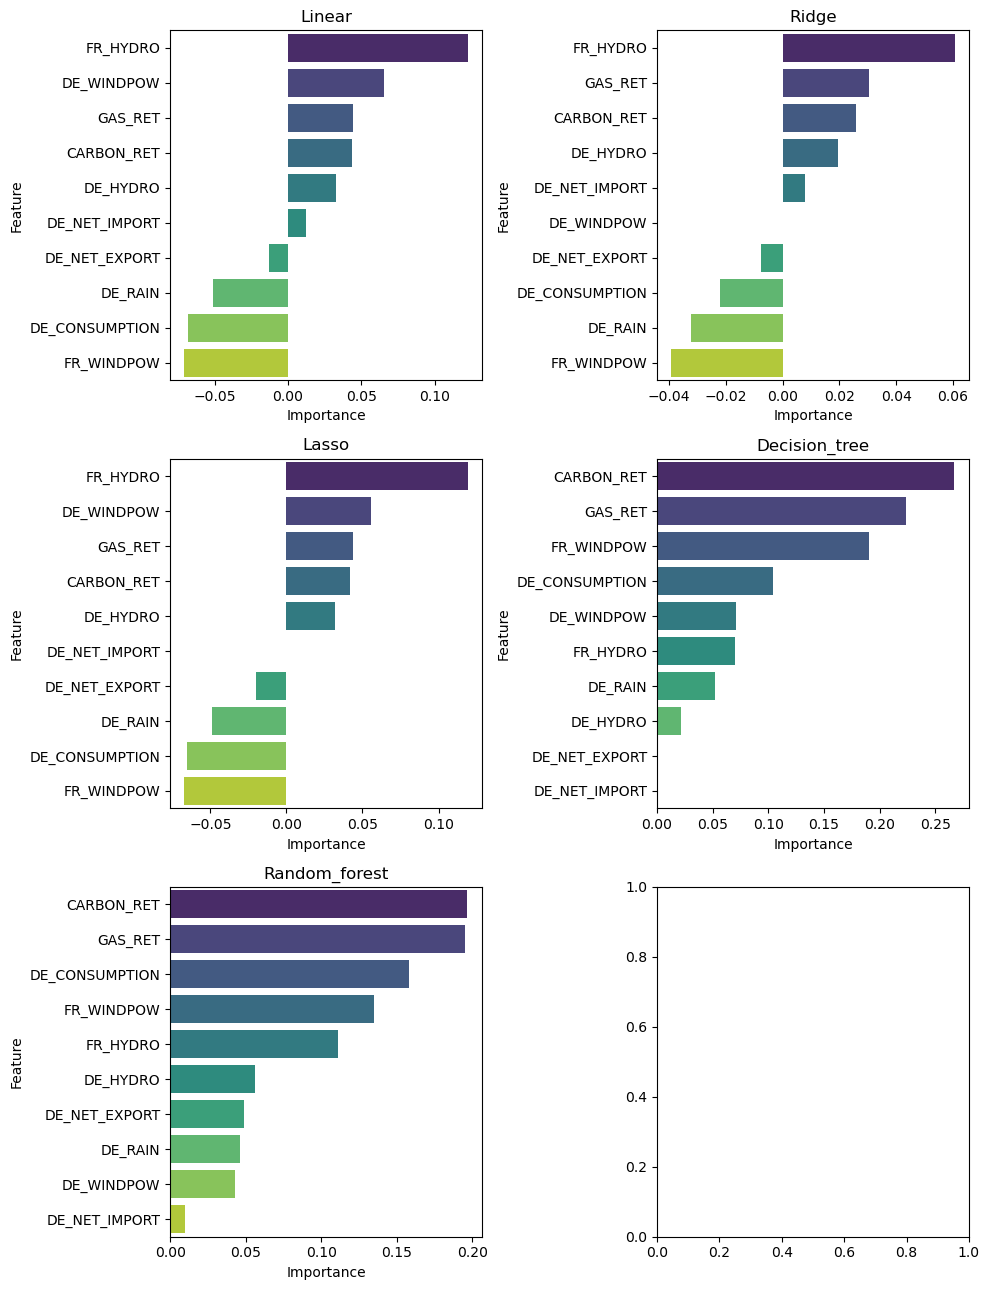

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

n_rows = 3
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 13))

axs = axs.flatten()

for i, model_name in enumerate(feature_importances):
    print(f"Creating plot for {model_name} model...")
    importances = feature_importances[model_name]
    
    importances_df = pd.DataFrame.from_dict(importances, orient='index', columns=['importance'])
    importances_df.sort_values('importance', ascending=False, inplace=True)

    sns.barplot(data=importances_df, y=importances_df.index, x='importance', palette='viridis', ax=axs[i])
    axs[i].set_title(f'{model_name.capitalize()}')
    axs[i].set_xlabel('Importance')
    axs[i].set_ylabel('Feature')
    
    print(f"Plot for {model_name} model created.")

plt.tight_layout()

plt.show()
